<a href="https://colab.research.google.com/github/noelmtv/Colab-Learning/blob/main/Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries#
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
!pip install fredapi



In [2]:
#define the list of tickers#
tickers = [
    "BUD", "TAP","SAM","STZ"
]


In [3]:
#SET THE END DATE TO TODAY#
end_date = datetime.today()

In [4]:
#Set start date#
start_date = end_date - timedelta(days=10*365)
print(start_date)

2015-02-27 07:01:07.677635


In [5]:
#download adjusted close prices#
#This is done because you dont want to underweight a stock that pays out dividends#
adj_close_df = pd.DataFrame()
print(adj_close_df.columns)

RangeIndex(start=0, stop=0, step=1)


In [6]:
# Download the prices for each ticker#
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data["Close"]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
print(adj_close_df)

                   BUD        TAP         SAM         STZ
Date                                                     
2015-02-27  101.896736  60.540970  267.600006  100.107346
2015-03-02  101.985229  60.556934  265.670013  101.206841
2015-03-03  101.582985  59.615585  258.869995  100.482574
2015-03-04  101.623222  59.272575  261.619995   99.854248
2015-03-05  102.725349  59.384247  260.519989   99.321960
...                ...        ...         ...         ...
2025-02-14   53.119999  60.360001  232.110001  162.940002
2025-02-18   53.000000  60.630001  226.869995  169.380005
2025-02-19   52.820000  60.139999  226.029999  172.419998
2025-02-20   53.150002  60.400002  225.149994  172.330002
2025-02-21   54.009998  60.330002  227.320007  175.970001

[2512 rows x 4 columns]


**Step 3: Calculate the Lognormal Returns**

In [8]:
#Calculate the Lognormal returns for each ticker#
#Use lognormal because the returns are additive#
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [9]:
#drop missing values#
log_returns = log_returns.dropna()

**Step 4: Calculate the Covariance Matrix**

In [10]:
#helps us calculate standard deviation/risk in the most optimal way possible#
# MULTIPLY BY 252 TO ANNUALISE THE DAILY RETURNS#

cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          BUD       TAP       SAM       STZ
BUD  0.075116  0.036998  0.025069  0.028230
TAP  0.036998  0.081637  0.027623  0.033487
SAM  0.025069  0.027623  0.163645  0.028059
STZ  0.028230  0.033487  0.028059  0.068624


**Section 5: Define portfolio Performance Metrics**

In [11]:
#calculate the portfolio standard deviation#
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [12]:
#Calculate Expected Returns using historical returns#
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [13]:
# calculate the Sharpe Ratio

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)


In [14]:
# Define your FRED API key
from google.colab import userdata
fred_api_key = userdata.get('fred_api_key')

# Get the risk free rate
from fredapi import Fred
fred = Fred(api_key = fred_api_key)
ten_year_treasury_rate = fred.get_series('GS10')/100

#Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)


0.0463


In [15]:
#Define the function to minimize (Negative Sharpe Ratio)
# In the case of scipy, there is no direct method to find the maximum value of a function so you gotta flip it.

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

    print(neg_sharpe_ratio)

In [16]:
#Set the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0,0.5) for _ in range(len(tickers))]

In [17]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.25 0.25 0.25 0.25]


In [18]:
#optimize the weights to maximise the sharpe ratio

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                                 method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_results.x

# Print the optimized weights
print("Optimized Weights:")
print(optimized_weights)

Optimized Weights:
[0.  0.5 0.  0.5]


**Analyse the optimal portfolio**

In [19]:
# Display the analytics of the optimal portfolio

for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimized_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal Portfolio Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

BUD: 0.0000
TAP: 0.5000
SAM: 0.0000
STZ: 0.5000

Optimal Portfolio Return: 0.0281
Optimal Portfolio Volatility: 0.2330
Optimal Sharpe Ratio: -0.0780


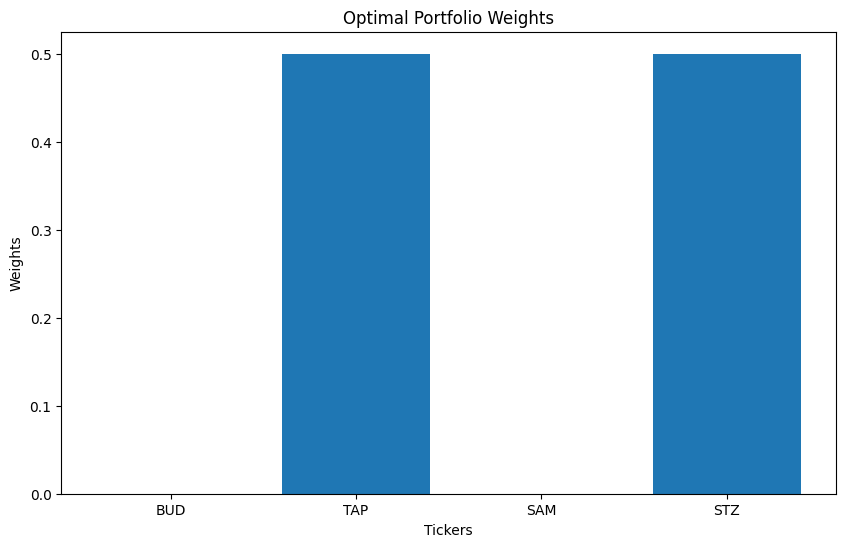

In [20]:
#display the final portfolio in a plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights')
plt.show()